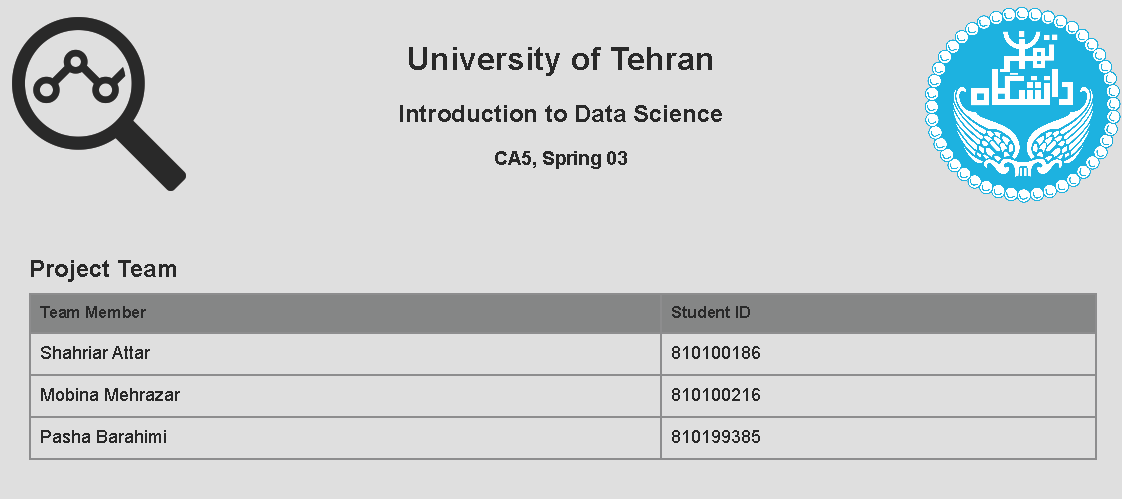

# Feature Engineering Techniques

## Table of Contents

- [Feature Engineering Techniques](#feature-engineering-techniques)
  - [Introduction](#introduction)
  - [Objectives](#objectives)
  - [Dataset Description](#dataset-description)
  - [Tasks](#tasks)
  - [Environment Setup](#environment-setup)
  - [Questions](#questions)
  - [References](#references)


## Introduction

In this assignment, we will apply feature engineering techniques to a football-related dataset with the aim of analyzing the likelihood of scoring a goal through a shot. Following this analysis, we will explore regression and cross-validation concepts in greater depth by implementing multivariate regression and k-fold cross-validation from scratch. These techniques will be applied to a preprocessed dataset related to cars. Lastly, we will compare the results obtained from our custom implementations with those from built-in Python libraries.

## Objectives

This assignment aims to:

- Implementing multivariate regression and k-fold cross-validation from scratch.
- Comparing the results obtained from custom implementations with those from built-in Python libraries.

## Tasks

1. Preprocessing

2. Multivariate Regression Implementation

3. Manual K-Fold Cross Validation Implementation

4. Comparison with Built-in Python Libraries

## Dataset Description

The dataset utilized for preprocessing, named "football.csv", encompasses football-related data, offering insights into various shot attributes, including timing, location (such as corner or penalty), and outcomes like "saved by the goalkeeper", "blocked by defenders", or "missed" shots.

For the implementation phase, a distinct preprocessed dataset, "cars.csv", focusing on automotive data, will be employed. This dataset contains comprehensive information about cars, and our objective is to leverage it to train custom multivariate regression and k-fold models for predicting the "Price in Thousands" and "Horsepower" attributes.

## Environment Setup

Let's begin with setting up the Python environment and importing the necessary libraries.

In [165]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [166]:
FOOTBALL_CSV = "../data/football.csv"
CLEANED_FOOTBALL_CSV = "../data/cleaned_football.csv"
CARS_CSV = "../data/cars.csv"

## Main Tasks

### Preprocessing

First, we will handle cleaning and analyzing the dataset, highlighting its statistical attributes and visualizing its features. Our goal is to identify the beneficial features and justify out conclusions convincingly. Additionally, we should employ feature engineering techniques to refine the dataset, either by removing or replacing less desirable features. To gain a deeper understanding of feature engineering, we'll train an arbitrary but appropriate model and evaluate the outcomes before and after preprocessing. Furthermore, to assess the importance of each feature, we will utilize the mutual information method to create a `pandas` dataframe with two columns: one for features and the other for their importance. Subsequently, we'll sort the dataframe in descending order based on importance and display the results.

Some notes to consider during preprocessing:

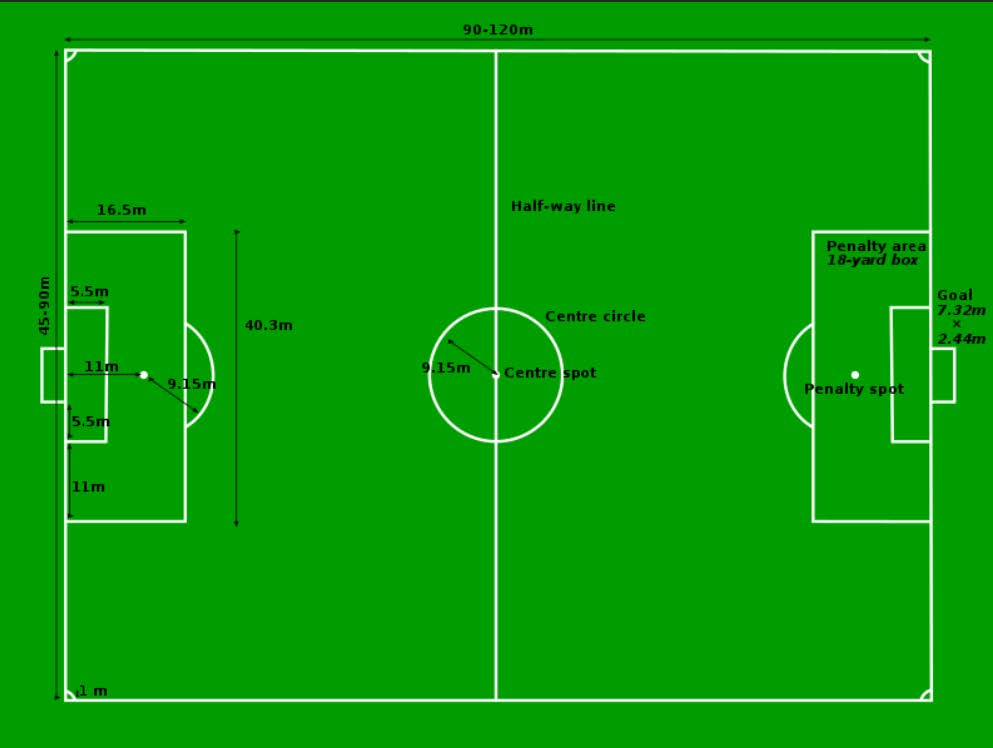

- The above figure shows a football pitch, to gain better insights into the dataset.
- We can apply various methods that we have learned throughout the course to fill missing values and manipulate categorical features in our data.
- We can consolidate similar features. For instance, we could treat "goal" and "own goal" as the same.
- We'll employ feature selection to exclude less significant features, thereby reducing the dimensionality and lowering computational costs.
- For a more thorough analysis, let's consider extracting new, more informative features from existing ones. For instance, we can calculate shot distance and angle using the following formulas and incorporate them into our analysis:

    - $distance = \sqrt{x^2 + y^2}$
    - $angle =$
      - $rad2deg(\arctan(\theta)): if \arctan(\theta) \geq 0$
      - $rad2deg(\arctan(\theta + \pi)): if \arctan(\theta) < 0$
    - Where $\theta = \frac{7.32x}{x^2 + y^2 - (\frac{7.32}{2})^2}$

In [167]:
df = pd.read_csv(FOOTBALL_CSV)

In [168]:
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


First, we will check for missing values in the dataset and then proceed with the preprocessing steps.

In [169]:
df.isnull().sum()

matchId                   0
playerId                  0
playType                  0
bodyPart                  0
x                         0
y                         0
interveningOpponents      0
interveningTeammates      0
interferenceOnShooter    34
minute                    0
second                    0
outcome                  34
dtype: int64

Since `outcome` is the target and we cannot fill missing values in the target column, we will drop rows with missing values in the `outcome` column.

In [170]:
df = df.dropna(subset=["outcome"])
df.isnull().sum()

matchId                  0
playerId                 0
playType                 0
bodyPart                 0
x                        0
y                        0
interveningOpponents     0
interveningTeammates     0
interferenceOnShooter    0
minute                   0
second                   0
outcome                  0
dtype: int64

The missing values in `interferenceOnShooter` correspond to the missing values in `outcome`, so no more missing values are present in the dataset.

Now we check for duplicate rows in the dataset and remove them if any are found.

In [171]:
df.duplicated().sum()

0

So everything is fine here. Now we check any outliers in the dataset.

In [172]:
df.describe()

,x,y,interveningOpponents,interveningTeammates,minute,second
count,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000
mean,14.597636,0.371103,2.537735,0.336857,48.540997,29.244517
std,7.834989,9.012600,1.385693,0.680940,26.393372,17.307217
min,0.000000,-33.920000,0.000000,0.000000,0.000000,0.000000
25%,8.480000,-5.740000,2.000000,0.000000,26.000000,14.000000
50%,12.470000,0.500000,2.000000,0.000000,49.000000,29.000000
75%,20.950000,6.730000,3.000000,0.000000,71.000000,44.000000
max,70.820000,33.920000,11.000000,7.000000,98.000000,59.000000


In [173]:
def plot_distributions(df: pd.DataFrame):
    numerical_columns = df.select_dtypes(include=[np.number]).columns

    figs, axes = plt.subplots(len(numerical_columns) // 2, 2, figsize=(12, 12))

    plt.subplots_adjust(hspace=0.5)
    for i, column in enumerate(numerical_columns):
        ax = axes[i // 2, i % 2]
        ax.hist(df[column], bins=20)
        ax.set_title(f"Distribution of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")

    plt.show()

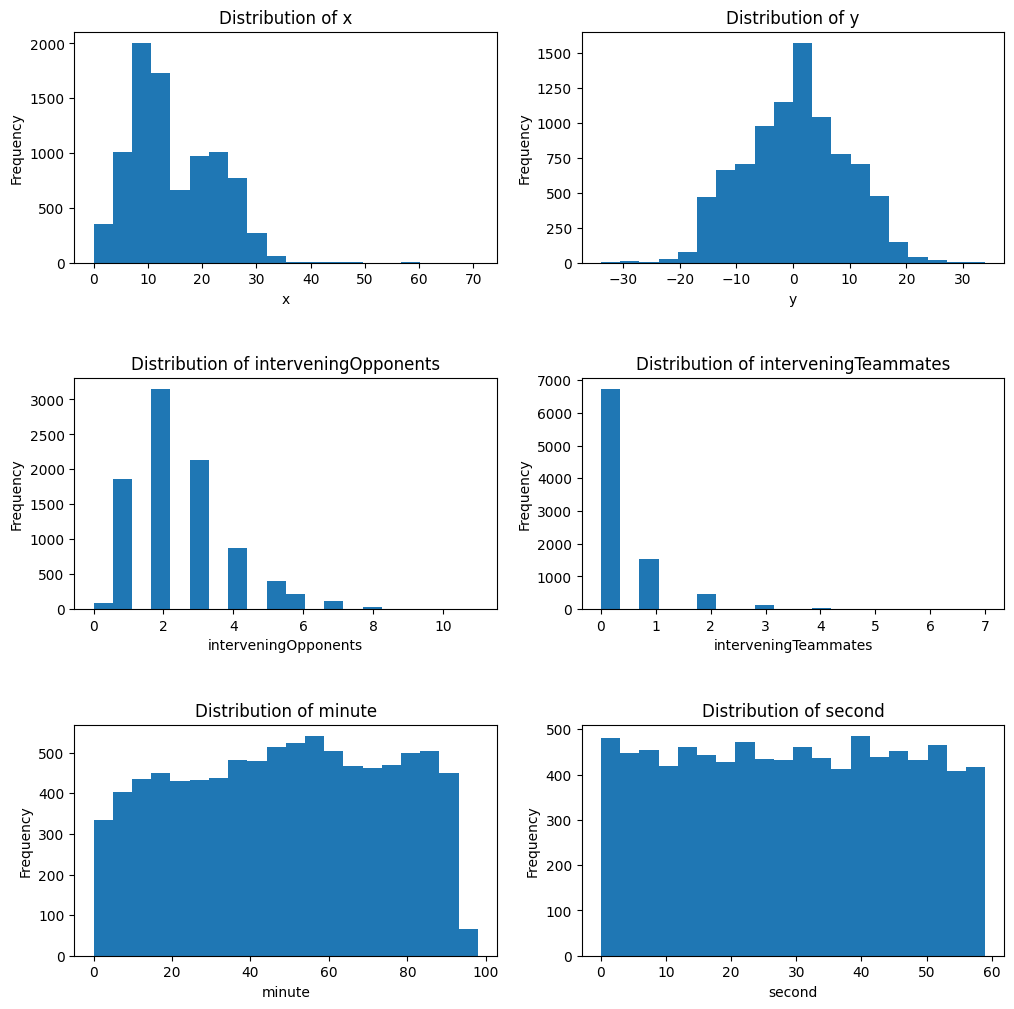

In [174]:
plot_distributions(df)

Now we delete outliers for columns `x`, `y`, `interveningOpponents`, `interveningTeammates`, since they are just rare cases and can be considered as outliers. Also `second` and `minute` columns are not necessary for our analysis, since they have uniform distribution and do not provide any useful information. For `bodyPart` and `playType` columns, we drop any value which amounts to less than 1% of the total data. For `interferenceOnShooter` column, we map the intensity to 0, 1 and 2.

In [175]:
def delete_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(df[column]))
    threshold = 3
    df = df[(z_scores < threshold)]

In [176]:
delete_outliers(df, "x")
delete_outliers(df, "y")
delete_outliers(df, "interveningOpponents")
delete_outliers(df, "interveningTeammates")

In [177]:
df.drop(columns=["second", "minute"], inplace=True)
# TODO: I didn't want to drop match id or player id since there could be a really good player ot match with many goal but i think they should be removed due to the distribution of the data

In [178]:
total_rows = len(df)

bodyPart_counts = df["bodyPart"].value_counts()
playType_counts = df["playType"].value_counts()

bodyPart_to_drop = bodyPart_counts[bodyPart_counts / total_rows < 0.01].index
playType_to_drop = playType_counts[playType_counts / total_rows < 0.01].index

df = df[~df["bodyPart"].isin(bodyPart_to_drop)]
df = df[~df["playType"].isin(playType_to_drop)]

In [179]:
interference_mapping = {
    "low": 0,
    "medium": 1,
    "high": 2
}

df["interferenceOnShooter"] = df["interferenceOnShooter"].map(interference_mapping)

Then we make the `outcome` column binary, where 1 represents a goal and 0 represents a non-goal.

In [180]:
df["outcome"].value_counts()

outcome
missed chance      3460
saved by keeper    2386
blocked shot       1755
goal               1065
hit the post        170
Name: count, dtype: int64

In [181]:
df["outcome"] = df["outcome"].apply(lambda x: 1 if x == "goal" else 0)

And then we delete the `p_` and `m_` before player and match ids respectively, and convert them to integers. 

In [182]:
df["playerId"] = df["playerId"].apply(lambda x: int(x.replace("p_", "")))
df["matchId"] = df["matchId"].apply(lambda x: int(x.replace("m_", "")))

Then we encode the categorical columns using one-hot encoding.

In [183]:
df = pd.get_dummies(df, columns=["bodyPart", "playType"])

Now we re-order the columns for more clarity.

In [184]:
df = df[[col for col in df.columns if col != "outcome"] + ["outcome"]]

In [185]:
df.head()

,matchId,playerId,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,bodyPart_head,bodyPart_left foot,bodyPart_right foot,playType_free kick,playType_open play,playType_penalty,outcome
0,91,103,13.47,-11.22,1,0,1,False,False,True,False,True,False,1
1,17,16,9.48,14.22,3,0,1,False,True,False,False,True,False,0
2,111,88,29.43,-1.25,6,2,0,False,True,False,True,False,False,0
3,142,87,26.93,1.00,4,1,1,False,False,True,False,True,False,0
4,117,9,10.72,5.24,2,0,1,False,False,True,False,True,False,1


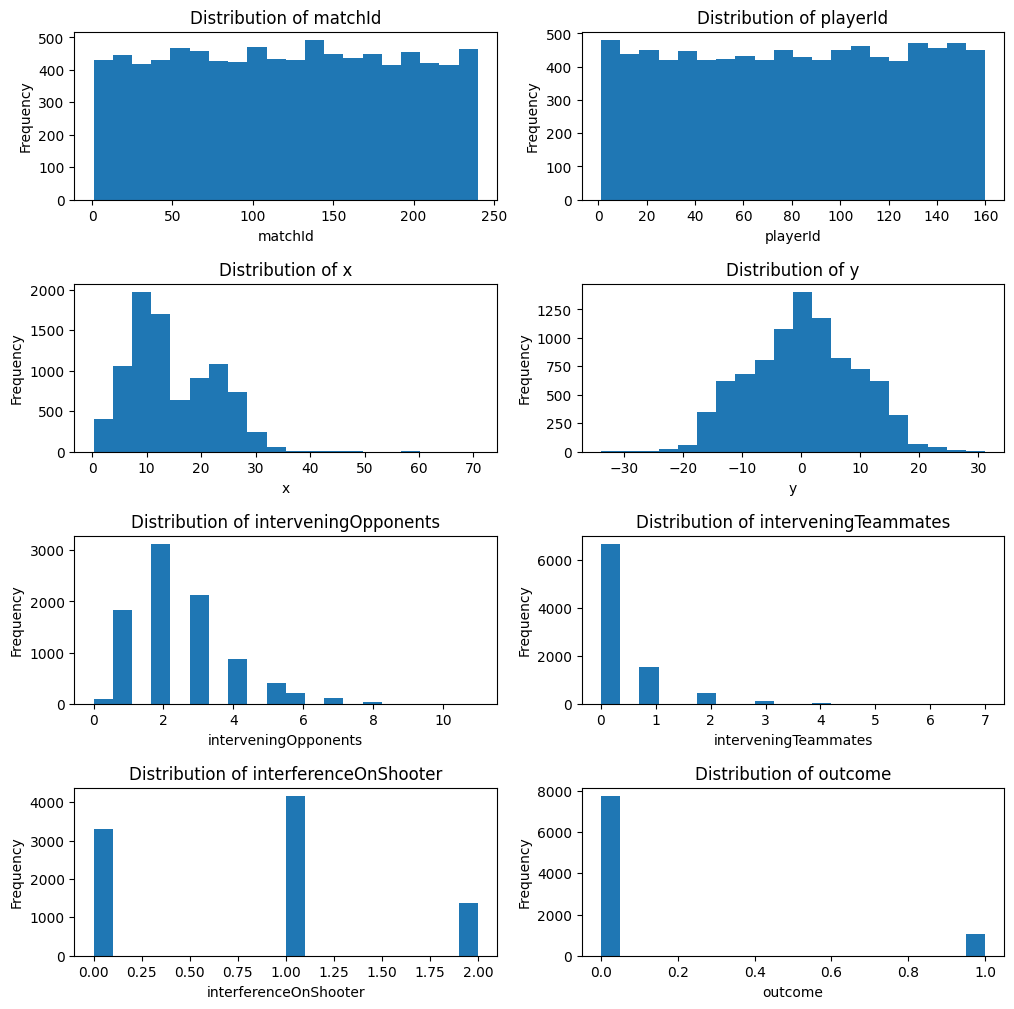

In [186]:
plot_distributions(df)

Then we check their effect on the target column and drop them if they are not significant.

In [187]:
def plot_heatmap(df: pd.DataFrame):
    plt.figure(figsize=(12, 12))
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    sns.heatmap(df[numerical_columns].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

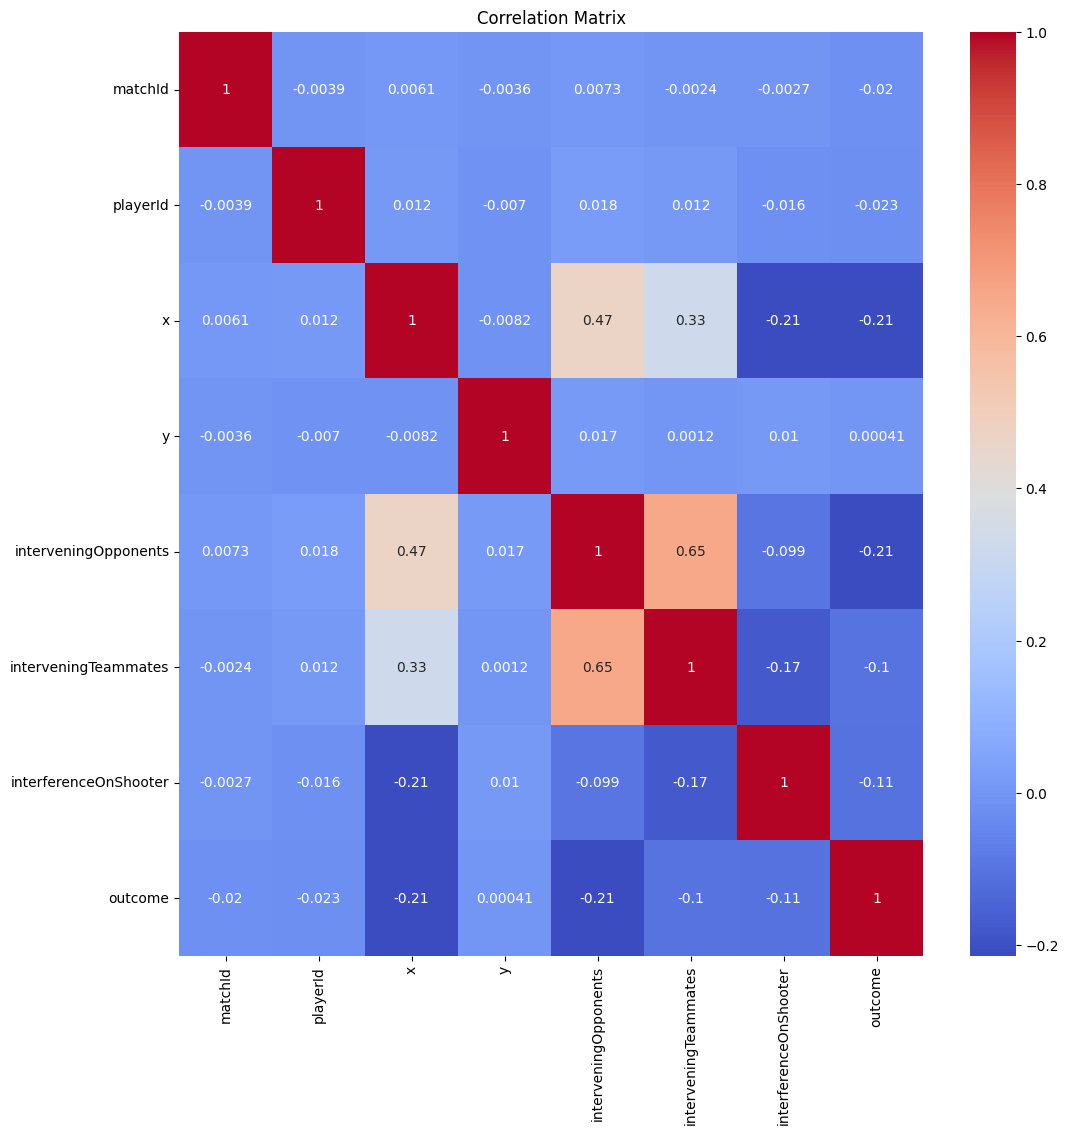

In [188]:
plot_heatmap(df)

In [189]:
correlation = df.corr()["outcome"]
print(correlation)

matchId                 -0.019521
playerId                -0.023353
x                       -0.213680
y                        0.000409
interveningOpponents    -0.212193
interveningTeammates    -0.101084
interferenceOnShooter   -0.109180
bodyPart_head           -0.001514
bodyPart_left foot       0.013742
bodyPart_right foot     -0.011757
playType_free kick      -0.028295
playType_open play      -0.093433
playType_penalty         0.239868
outcome                  1.000000
Name: outcome, dtype: float64


In [190]:
# drop the insignificant columns

In [191]:
# perform feature engineering

In [192]:
df.to_csv(CLEANED_FOOTBALL_CSV, index=False)

### Multivariate Regression Implementation

We'll implement multivariate regression from scratch and use the gradient descent algorithm to update the weights. Then, we'll validate the regression model by providing a visual comparison between the predicted and actual values for "Price in Thousands" and “Horsepower”. Additionally, we'll plot the accuracy across different random states for a more robust verification. Finally, we will display a learning curve to illustrate the progression of the regression process.

In [193]:
# code

### Manual K-Fold Cross Validation Implementation

We'll implement K-Fold cross-validation from scratch. As in the previous section, we will use the gradient descent algorithm to adjust the weights. Then, we would validate your custom K-Fold implementation using statistical metrics. Finally, let's display a learning curve upon completion.

In [194]:
# code

### Comparison with Built-in Python Libraries

Now, let's compare the results from our custom implementations in sections 2 and 3 with those obtained using built-in Python libraries, and report the findings.

In [195]:
# code

## Questions

1. **Describe your strategy for addressing challenges such as handling missing values and categorical features. Could you also elaborate on your feature selection metrics and explain the rationale behind them?**

2. **Why didn’t we use regression to predict whether a shot would result in a goal?**

3. **How would you go about verifying the accuracy of the given formula used to calculate the shot angle in the preprocessing section?**

4. **Discuss the advantages and disadvantages of k-fold cross-validation. Can you also explain other types of cross-validation methods that could address the limitations and issues associated with k-fold cross-validation?**

5. **What metrics did you use to evaluate your manual implementations of multivariate regression and k-fold cross-validation, and why did you choose them?**



## References

